# 5.5. How well are doing and can we do better?

## Loading the data: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [26]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [27]:
import pathlib
data_dir = pathlib.Path('chest_xray')

In [28]:
image_count = len(list(data_dir.glob('train/*/*.jpeg')))
image_count

5216

In [29]:
CLASS_NAMES = np.array(list(set([item.name for item in data_dir.glob('*/*') if item.name.upper() == item.name])))
CLASS_NAMES

array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

In [30]:
import os

# more info: https://www.tensorflow.org/tutorials/load_data/images

BATCH_SIZE = 16
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return 1 if parts[-2] == 'PNEUMONIA' else 0
def decode_img(img):
    # convert the compressed string to a 1D tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    #ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

def get_dataset(path):
    list_ds = tf.data.Dataset.list_files(os.path.join(str(data_dir), path, '*/*'))
    labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    ds = prepare_for_training(labeled_ds)

    return ds

In [31]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(np.squeeze(image_batch[n]))
        plt.title('Pneumonia' if label_batch[n] else 'Normal')
        plt.axis('off')

(16,) [1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1]


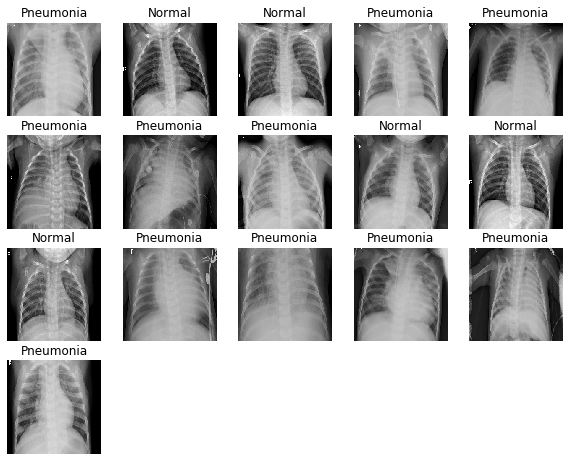

In [32]:
train_ds = get_dataset('train')
image_batch, label_batch = next(iter(train_ds))
print(label_batch.shape, label_batch.numpy())
show_batch(image_batch.numpy(), label_batch.numpy())

## Base model

In [76]:
base_model = tf.keras.applications.Xception(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False)

83689472/83683744 [==============================] - 5s 0us/step


In [77]:
#image_3chan_batch = np.repeat(image_batch, 3, -1)
#image_3chan_batch.shape

In [78]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 2048)


## Our own top layers

In [88]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 132

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  132


In [89]:
base_model.summary()


Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [90]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(16, 2048)


In [91]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [92]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [93]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [94]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [95]:
val_ds = get_dataset('val')
loss_val, accuracy_val = model.evaluate(val_ds)

1/1 [==============================] - 1s 1s/step - loss: 0.7425 - accuracy: 0.5625


In [96]:
test_ds = get_dataset('test')
loss_test, accuracy_test = model.evaluate(test_ds)

39/39 [==============================] - 34s 873ms/step - loss: 0.6437 - accuracy: 0.5144


## How well are we doing?

In [97]:
counts = {'NORMAL': 0, 'PNEUMONIA': 1}
for batch in test_ds:
    labels = batch[1]
    for elem in labels:
        class_name = 'PNEUMONIA' if elem == 1 else 'NORMAL'
        counts[class_name] += 1
counts

{'NORMAL': 234, 'PNEUMONIA': 391}

In [98]:
counts['NORMAL'] / (counts['PNEUMONIA'] + counts['NORMAL'])

0.3744

## Training

In [99]:
epochs = 15
model.fit(train_ds,
          epochs=epochs,
          validation_data=val_ds,
          verbose=1)

Epoch 1/15
326/326 [==============================] - 352s 1s/step - loss: 0.5425 - accuracy: 0.6959 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
326/326 [==============================] - 331s 1s/step - loss: 0.4323 - accuracy: 0.8539 - val_loss: 0.6525 - val_accuracy: 0.5625
Epoch 3/15
326/326 [==============================] - 332s 1s/step - loss: 0.3758 - accuracy: 0.8738 - val_loss: 0.6091 - val_accuracy: 0.6875
Epoch 4/15
326/326 [==============================] - 332s 1s/step - loss: 0.3369 - accuracy: 0.8877 - val_loss: 0.5910 - val_accuracy: 0.6875
Epoch 5/15
326/326 [==============================] - 332s 1s/step - loss: 0.3052 - accuracy: 0.8957 - val_loss: 0.5858 - val_accuracy: 0.6875
Epoch 6/15
326/326 [==============================] - 333s 1s/step - loss: 0.2923 - accuracy: 0.8949 - val_loss: 0.5813 - val_accuracy: 0.6875
Epoch 7/15
326/326 [==============================] - 335s 1s/step - loss: 0.2793 - accuracy: 0.9038 - val_loss: 0.5827 - val_accuracy

In [100]:
loss_val, accuracy_val = model.evaluate(val_ds)

1/1 [==============================] - 1s 799ms/step - loss: 0.5277 - accuracy: 0.6875


In [101]:
loss_test, accuracy_test = model.evaluate(test_ds)

39/39 [==============================] - 32s 811ms/step - loss: 0.4967 - accuracy: 0.7163


In [ ]:
# 1. Get more data: real data OR data augmentation - look it up in tensorflow
# 2. Experiment with other models as well OR experiment with unfreezing more layers
# 3. Add your own multiple layers (maybe with dropout for regularization)
# 4. Add your own convolutional layers
# 5. Use a model pretrained on medical imagery data